In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
cd ../src

/home/theo/mva/altegrad/challenge/src


In [29]:
from util import *
from params import *
from imports import *


from data.dataset import *
from data.text_processing import *


from models import *

In [30]:
seed_everything(SEED)

# Labels

In [31]:
sub = pd.read_csv(DATA_PATH + 'graph_baseline.csv')

In [32]:
# df_train = pd.read_csv(DATA_PATH + 'train_noduplicates.csv', names=['node', 'class'])
df_train = pd.read_csv(DATA_PATH + 'train.csv', names=['node', 'class'])
df_test = pd.read_csv(DATA_PATH + 'test.csv', names=['node'])

In [33]:
CLASSES

['business/finance',
 'education/research',
 'entertainment',
 'health/medical',
 'news/press',
 'politics/government/law',
 'sports',
 'tech/science']

In [34]:
len(df_train), len(df_test)

(2125, 560)

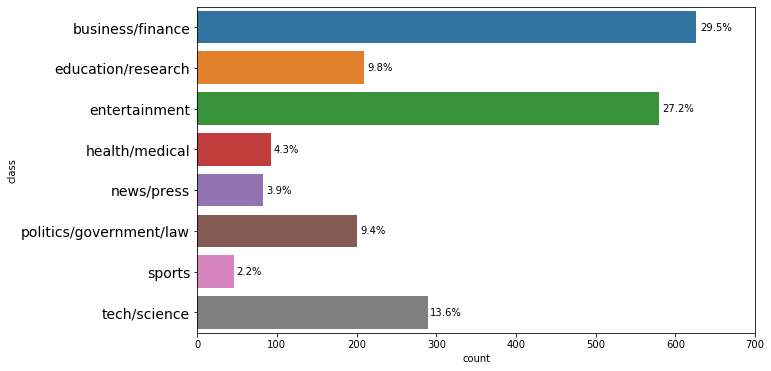

In [35]:
plot_categorical(df_train['class'], orient='h', ticks=CLASSES, order=CLASSES, xlim=(0, 700))

In [36]:
nodes_train = list(df_train['node'])
nodes_test = list(df_test['node'])
nodes = nodes_test + nodes_train

In [37]:
y_train = np.array([CLASSES.index(c) for c in df_train['class'].values])

In [38]:
CLASSES

['business/finance',
 'education/research',
 'entertainment',
 'health/medical',
 'news/press',
 'politics/government/law',
 'sports',
 'tech/science']

# Texts

In [39]:
TRANSLATE = False
filename = 'df_texts_trans' if TRANSLATE else 'df_texts'

## Treat data

### Extract texts

In [40]:
texts = []

for i in tqdm(range(NB_NODES)):
    try:
        with codecs.open(TEXT_PATH + f'{i}', encoding='utf-8') as f:
            text = f.read().replace("\n", "").lower()
    except:
        with codecs.open(TEXT_PATH + f'{i}', encoding='latin-1') as f:
            text = f.read().replace("\n", "").lower()

    text = ' '.join(text.split(' ')[:5000])
    texts.append(text)

100%|██████████| 28003/28003 [00:28<00:00, 984.12it/s] 


In [41]:
df_texts = pd.DataFrame()
df_texts['text'] = texts
df_texts['len'] = df_texts['text'].apply(lambda x: len(x.split(' ')))

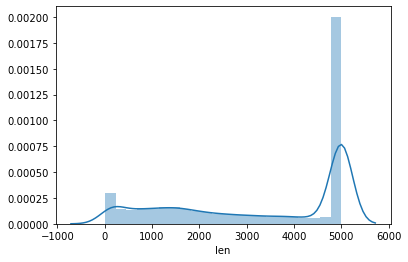

In [42]:
sns.distplot(df_texts['len'])
plt.show()

### Treat Texts 

In [43]:
df_texts['treated_text'] = treat_texts(df_texts['text'])

100%|██████████| 8/8 [00:19<00:00,  2.46s/it]


### Removing some NaNs 

In [44]:
df_texts.to_csv(f'../output/{filename}.csv', index=False)
print(f'Saved to ../output/{filename}.csv')


df_texts = pd.read_csv(f'../output/{filename}.csv')
df_texts.fillna('No text', inplace=True)

Saved to ../output/df_texts.csv


### Preview

In [45]:
for i in nodes_train[:1]:
    print(f"Node #{i} : Class {df_train[df_train['node'] == i]['class']}")
    print(df_texts['treated_text'][i])
    print('\n ---------------------- \n')

Node #9032 : Class 0    health/medical
Name: class, dtype: object
#polepharma » flux polepharma » flux des commentaires polepharma polepharma ﻿ recherche submit (button) toggle navigation polepharma * polepharma + qui sommes-nous ? + organigramme + les chiffres clés + un réseau * territoires + région centre-val de loire + région normandie + conseil départemental d'eure&loir + chartres metropole + metropole de rouen + agglo du pays de dreux + agglo evreux portes de normandie + agglo seine&eure + agglo de tours plus * performance industrielle + excellence opérationnelle + maintenance + packaging + supply chain + usine du futur * talents * relations publiques * innovation + biomédicaments + fédérer + collaborer + promouvoir adhérer à polepharma espace adhérent rechercher un adhérent je découvre les métiers de la filière pharmaceutique polepharma médiathèque espace presse polepharma polepharma ﻿ recherche submit polepharma polepharma * polepharma + qui sommes-nous ? + organigramme + les ch

## Parsing errors

In [46]:
def detect_error(text):
    errors = ['forbidden', '301', '403', '404', 'permission']
    if (50 < len(text.split(' ')) < 200)  and any(error in text for error in errors):
        return 1
    elif len(text.split(' ')) < 50:
        return 1
    else:
        return 0

In [47]:
if "error" not in df_texts.columns:
    df_texts["error"] = df_texts['treated_text'].astype(str).apply(detect_error)

print(Counter(df_texts["error"]))

Counter({0: 26248, 1: 1755})


# Translation

## Detecting languages

In [48]:
from googletrans import Translator
from langdetect import detect, DetectorFactory

DetectorFactory.seed = 0

In [49]:
languages = []
txts = df_texts['treated_text'].values

for txt in tqdm(txts):
    try:
        l = detect(txt)
    except:
        l = 'unk'
    languages.append(l)
df_texts['language'] = languages

100%|██████████| 28003/28003 [09:29<00:00, 49.15it/s]


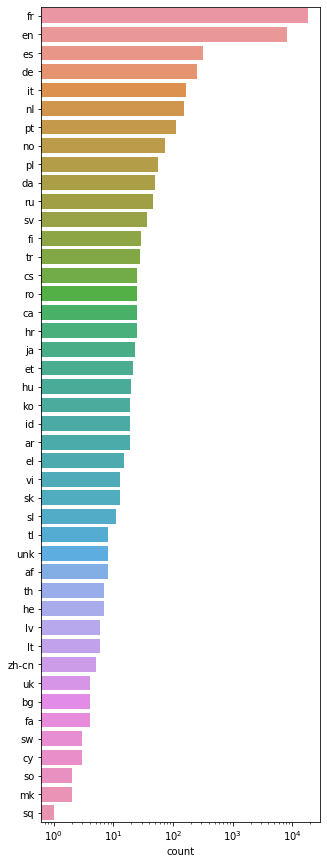

In [50]:
languages = df_texts['language'].values
order = np.array(sorted(Counter(languages).items(), key=operator.itemgetter(1)))[:, 0][::-1]

plt.figure(figsize=(5, 15))
sns.countplot(y=languages, order=order)
plt.xscale('log')

## Translating
This line should translate about 331 of the 361 texts. The Google Translate API sometimes behave weirdly

In [51]:
NUM_CHARS = 5000

In [52]:
if TRANSLATE:
    to_translate = []
    translated = {}
    count = 0
    translator = Translator()

    for i, (txt, lang, error) in tqdm(enumerate(df_texts[['treated_text', 'language', 'error']].values)):
        if i in nodes and not error and lang != 'fr':
            to_translate.append(i)
            if i not in translated.keys():
                try:
                    translated_txt = translator.translate(txt[:NUM_CHARS], dest='fr')
                    translated[i] = translated_txt.text
                except:
                    pass

    print(f'{len(to_translate)} texts to translate')
    print(f'Translated {len(translated)} texts')

In [53]:
lens = []
if TRANSLATE:
    for k in translated.keys():
        df_texts['treated_text'][k] = translated[k]
        df_texts['language'][k] = 'fr'

## Tokenize

In [54]:
def tokenize_df(text, transformer):
    tokens = transformer.tokenizer.tokenize(text)
    ids = transformer.tokenizer.convert_tokens_to_ids(tokens)
    if not len(ids):
        ids = [0]
    return ' '.join(list(np.array(ids).astype(str)))

In [55]:
model = Transformer('camembert-base')
df_texts['ids'] = df_texts['treated_text'].astype(str).apply(lambda x: tokenize_df(x, model))

In [56]:
df_texts.to_csv(f'../output/{filename}.csv', index=False)
print(f'Saved to ../output/{filename}.csv')

Saved to ../output/df_texts.csv
